In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import xarray as xr

In [3]:
az.style.use("arviz-grayscale")
from cycler import cycler
default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc('axes', prop_cycle=default_cycler)
plt.rc('figure', dpi=300)
np.random.seed(123)

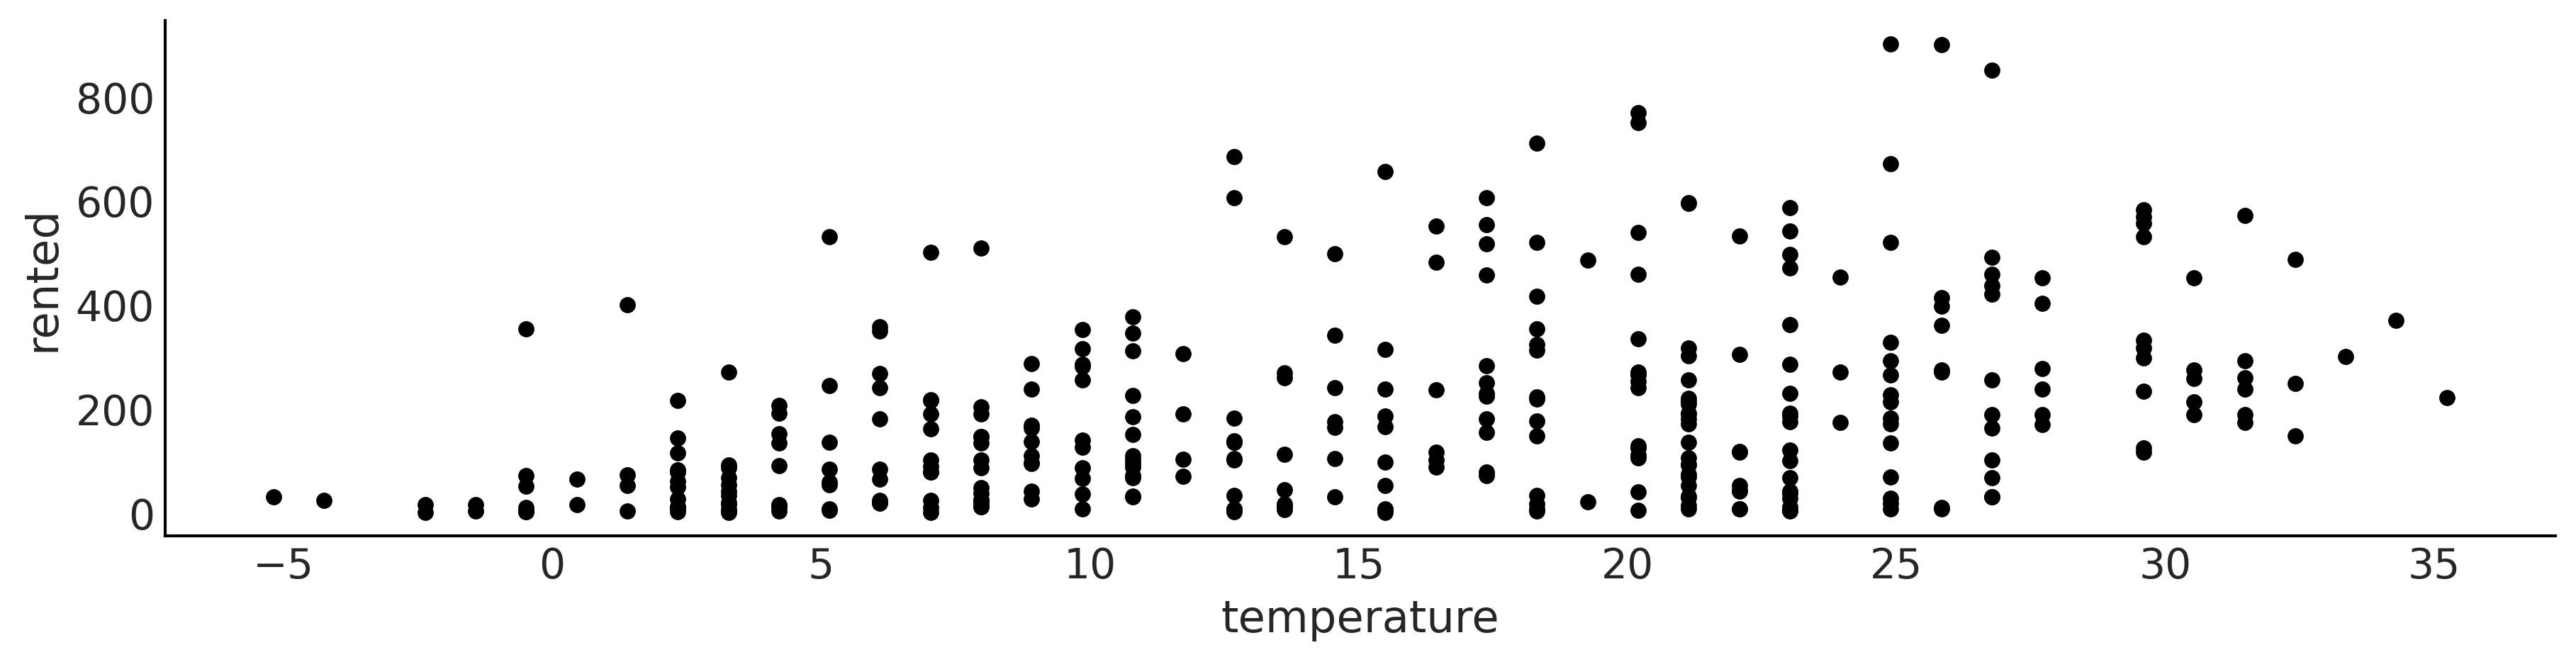

In [4]:
bikes = pd.read_csv("data/bikes.csv")
t = bikes.temperature.values
t_min=-8
t_max=39
bikes.temperature = t * (t_max-t_min) + t_min
bikes.plot(x="temperature", y="rented", figsize=(12, 3), kind="scatter")
plt.savefig("../fig/bike_temperature.png")

In [5]:
with pm.Model() as model_lb:
    α = pm.Normal('α', mu=0, sigma=100)
    β = pm.Normal('β', mu=0, sigma=10)
    ϵ = pm.HalfCauchy('ϵ', 10)
    μ = pm.Deterministic('μ', α + β * bikes.temperature)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=bikes.rented)
    idata_lb = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ϵ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


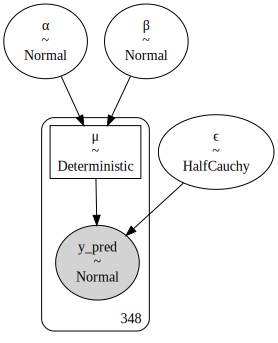

In [6]:
pm.model_to_graphviz(model_lb)

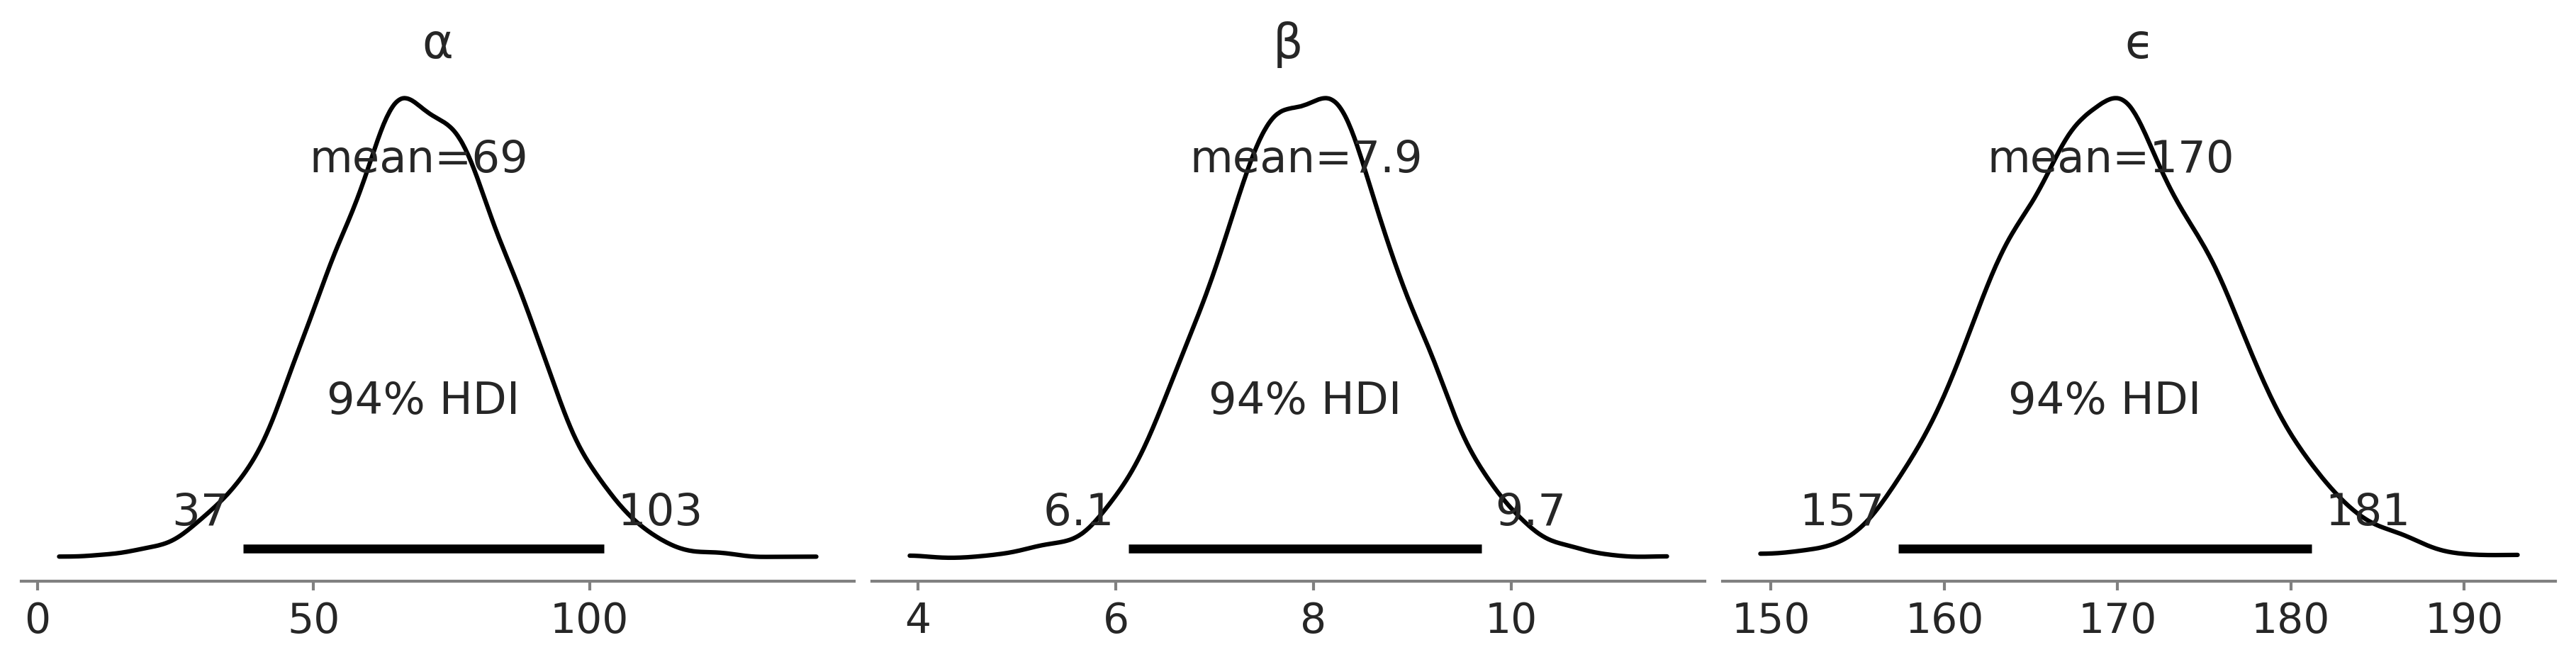

In [7]:
az.plot_posterior(idata_lb, var_names=['α', 'β', 'ϵ'], figsize=(12, 3))
plt.savefig("../fig/linear_bikes_posterior.png")

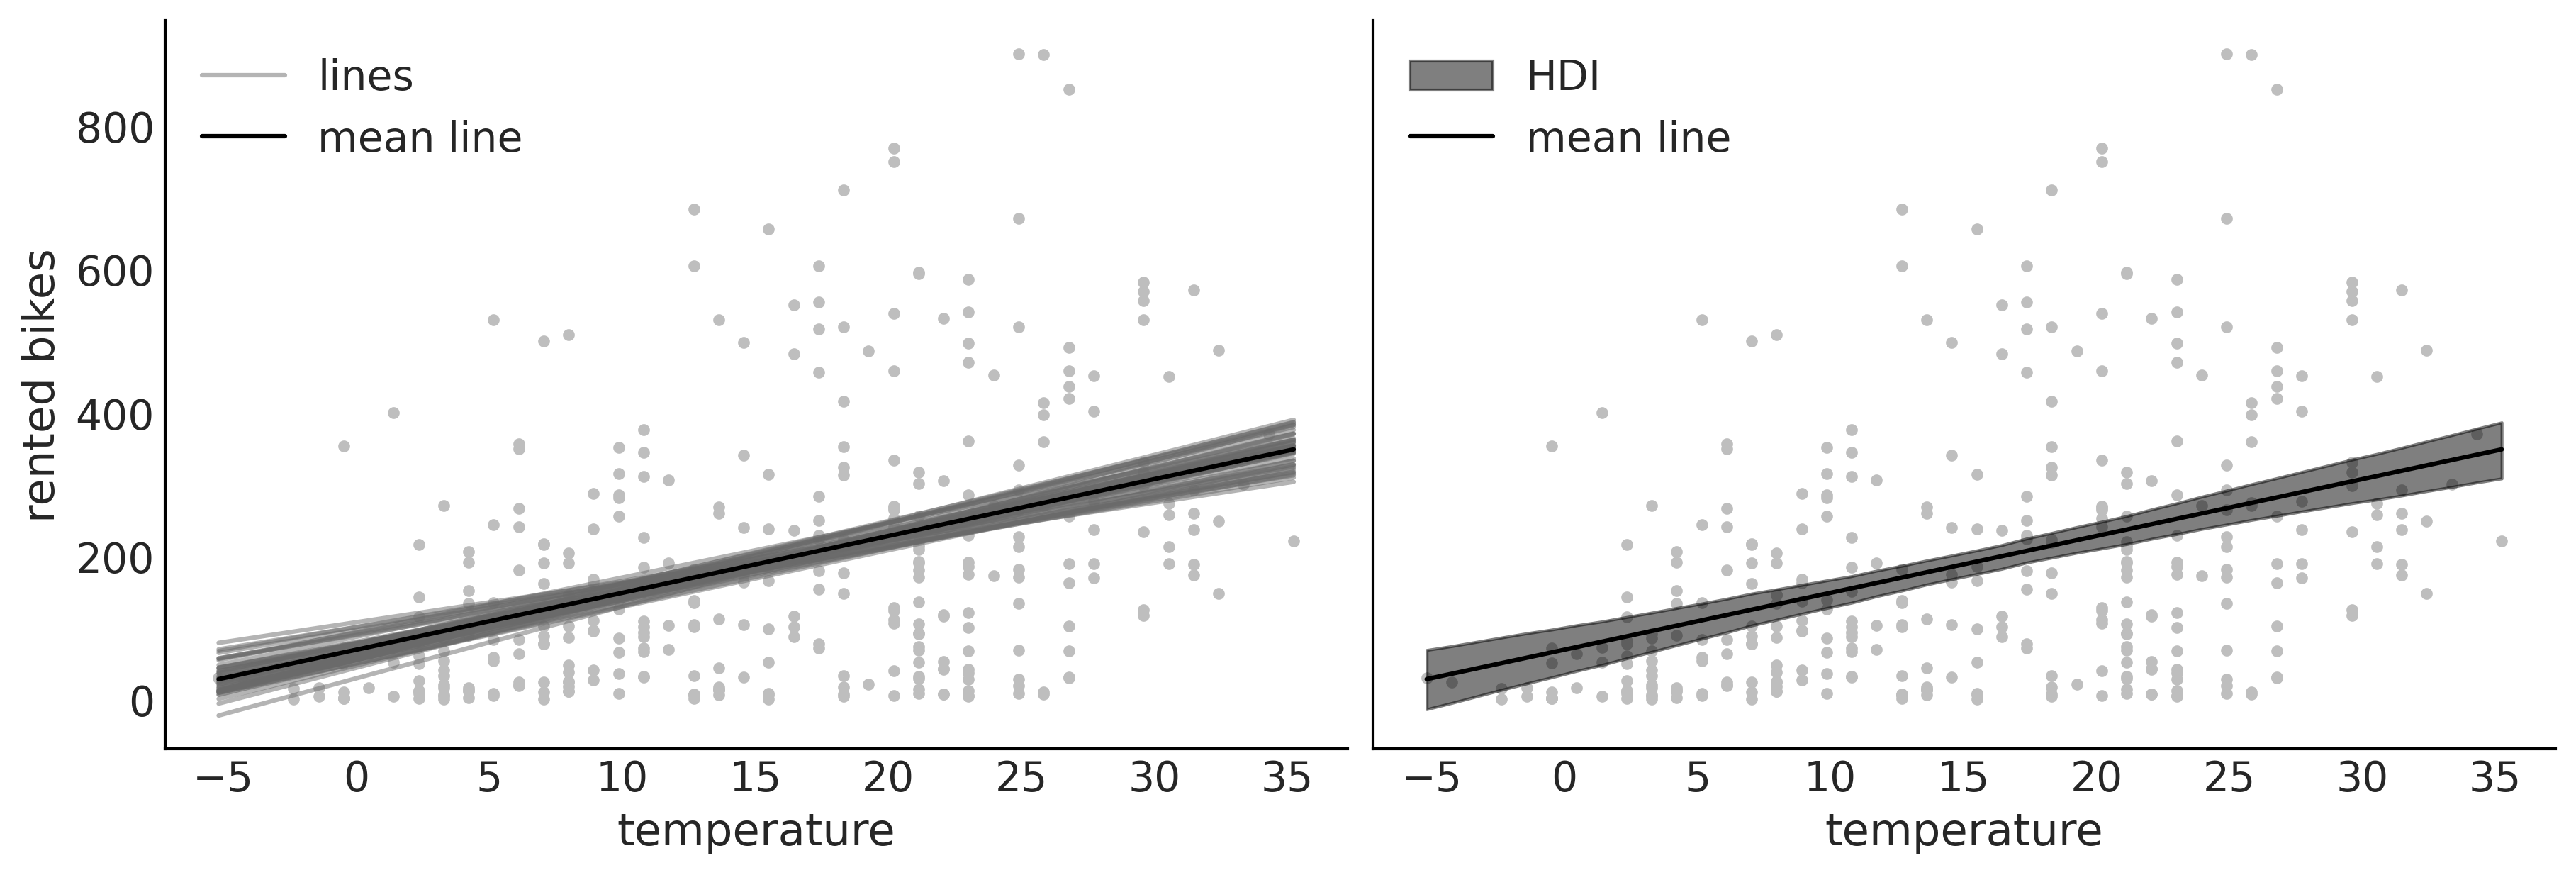

In [91]:

posterior = az.extract(idata_lb, num_samples=50)
x_plot = xr.DataArray(np.linspace(bikes.temperature.min(), bikes.temperature.max(), 50), dims="plot_id")
mean_line = posterior['α'].mean() + posterior['β'].mean() * x_plot
lines = posterior['α'] + posterior['β'] * x_plot
hdi_lines = az.hdi(idata_lb.posterior['μ'])


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].plot(bikes.temperature, bikes.rented, 'C2.', zorder=-3)
lines_ = axes[0].plot(x_plot, lines.T, c='C1', alpha=0.5, label='lines')
plt.setp(lines_[1:], label="_")
axes[0].plot(x_plot, mean_line, c='C0', label='mean line')
axes[0].set_xlabel('temperature')
axes[0].set_ylabel('rented bikes')
axes[0].legend()

axes[1].plot(bikes.temperature, bikes.rented, 'C2.', zorder=-3)
idx = np.argsort(bikes.temperature.values)
axes[1].fill_between(bikes.temperature[idx], hdi_lines["μ"][:,0][idx], hdi_lines["μ"][:,1][idx],
                     color="C0", label='HDI', alpha=0.5)
axes[1].plot(x_plot, mean_line, c='C0', label='mean line')
axes[1].set_xlabel('temperature')
axes[1].legend()
plt.savefig("../fig/linear_bikes_posterior_lines.png")
